# Train your image classifier in python

This tutorial repeats in Python the same steps as the ones viewed in class with the Marcelle interactive application.

We will step through the process of loading and preparing skin lesion images for a machine learning classification task. Using the `load_images_and_labels` function from our utilities module, we will load both training and testing datasets from a GitHub repository. This function will handle fetching image URLs, downloading images, and extracting labels for each image. By the end of this tutorial, you will have two DataFrames: one for training and one for testing, which will be used to train a machine learning model for the task of skin lesion classification.

## 1. Download data and store them in a Pandas dataframe

In [1]:
# Import the function `load_images_and_labels` from the `utilities` module.
# The `utilities` module contains helpful functions to streamline the process of data handling.
from utilities import load_images_and_labels

df_train = load_images_and_labels('train')
df_test = load_images_and_labels('test')

At this point, the variables `df_train` and `df_test` hold the images and labels of our training and testing sets, respectively. These will be the input for any subsequent preprocessing, model training, or evaluation steps.

In [59]:
df_train.head()

,filename,image,label,features
0,benign_train_1.png,<PIL.Image.Image image mode=RGB size=224x224 a...,benign,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,benign_train_10.png,<PIL.Image.Image image mode=RGB size=224x224 a...,benign,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,benign_train_11.png,<PIL.Image.Image image mode=RGB size=224x224 a...,benign,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,benign_train_12.png,<PIL.Image.Image image mode=RGB size=224x224 a...,benign,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,benign_train_13.png,<PIL.Image.Image image mode=RGB size=224x224 a...,benign,"[0.0, 0.0, 5.3492703, 0.0, 0.0, 0.0, 0.0, 0.0,..."


## 2. Extract features from images using a pre-trained neural network

This section of the tutorial will guide you through the process of leveraging a pre-trained MobileNet model from Keras for the purpose of feature extraction. We'll use the MobileNet model as a base to process images into a form that can be used to train a simpler classifier on top of the complex patterns that MobileNet can recognize.

In [125]:
# Import necessary packages.

import numpy as np # `numpy` is a fundamental package for scientific computing with Python.
from keras.applications import MobileNet # `MobileNet` is a pre-trained model provided by Keras, suitable for mobile and embedded vision applications.
from keras.preprocessing.image import img_to_array # `img_to_array` converts a PIL Image instance to a numpy array.
from tensorflow.keras.applications.mobilenet import preprocess_input # `preprocess_input` will preprocess the image data to match the format expected by MobileNet.
from keras import Model # `Model` from Keras is used to instantiate a new model object.
from tensorflow.keras.layers import GlobalAveragePooling2D



# Initialize the base MobileNet model with ImageNet weights and without the top classification layer.
# This will allow us to use the convolutional base to extract features from our images.
# `weights="imagenet"` means we load weights pre-trained on ImageNet.
# `include_top=False` indicates that we do not include the top (or last) fully connected layer.
# base_model = MobileNet(weights="imagenet", input_shape=(224, 224, 3), output_shape=(7, 7, 1024), include_top=False)
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3), alpha=1.0)


target_layer = base_model.output

# Add Global Average Pooling layer to reduce spatial dimensions
global_average_layer = GlobalAveragePooling2D()(target_layer)

# Create the new model with the Global Average Pooling output
model = Model(inputs=base_model.input, outputs=global_average_layer)

# This model will now output a 1024-dimensional vector for each input image
model.summary()


Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128 

In [126]:
import pandas as pd # `pandas` is a Python package for data manipulation and analysis.

# Function definition to extract features from a dataframe of images.
def extract_features(df: pd.DataFrame, model : Model) -> np.ndarray:
    """AI is creating summary for extract_features

    Args:
        df (pd.DataFrame): Dataframe of images.
        model (Model): Model to extract features from.

    Returns:
        np.ndarray: Array of flattened features.
    """
    # `img_to_array` converts the PIL Image into a numpy array.
    # `preprocess_input` prepares the image for MobileNet (e.g., scaling pixel values).
    images = np.array([img_to_array(img) for img in df['image'].values])
    images = preprocess_input(images)

    # Use the provided model (e.g., MobileNet) to predict features.
    # This acts as a feature extractor, turning images into feature vectors.
    features = model.predict(images)

    # Reshape the features to a 2D array where each row is a set of features for one image.
    # The model outputs a 4D tensor, but we need a 2D array for the classifier.
    flattened_features = features.reshape(features.shape[0], -1)

    # The function returns the array of flattened features ready for use in training a classifier.
    return flattened_features

In [127]:
df_train['features'] = list(extract_features(df_train, model))
df_test['features'] = list(extract_features(df_test, model))

3/3 [==============================] - 0s 84ms/step


In [128]:
df_train.head()

,filename,image,label,features
0,benign_train_1.png,<PIL.Image.Image image mode=RGB size=224x224 a...,benign,"[0.0, 0.0, 1.7514466, 1.038351, 0.0, 0.4542227..."
1,benign_train_10.png,<PIL.Image.Image image mode=RGB size=224x224 a...,benign,"[0.0, 0.0, 0.45081282, 1.2973214, 0.0, 0.26359..."
2,benign_train_11.png,<PIL.Image.Image image mode=RGB size=224x224 a...,benign,"[0.0, 0.06741032, 0.0, 1.5003142, 0.0, 0.07763..."
3,benign_train_12.png,<PIL.Image.Image image mode=RGB size=224x224 a...,benign,"[0.09131607, 0.14149629, 0.0, 1.8003716, 0.039..."
4,benign_train_13.png,<PIL.Image.Image image mode=RGB size=224x224 a...,benign,"[0.0, 0.0, 3.0407, 2.220454, 0.053016722, 0.03..."


In [129]:
df_train.features[0].shape

(1024,)

## 3. Define neural network architecture

In this section of the tutorial, we focus on constructing a simple neural network architecture using Keras, which is now integrated within TensorFlow. We'll go through the process of defining a Sequential model, which allows us to create models layer-by-layer. You'll see how we can add densely connected layers and compile the model with an optimizer and loss function suitable for a binary classification task.

In [151]:
# Import necessary packages.
from keras.models import Sequential # `Sequential` groups a linear stack of layers into a `tf.keras.Model`.
from keras.layers import Dense, Flatten # `Dense` implements the operation: `output = activation(dot(input, kernel) + bias)`.
from tensorflow.keras.optimizers.legacy import Adam # `Adam` is an optimization algorithm that can be used instead of the classical stochastic gradient descent procedure to update network weights iterative based on training data.

# Define the sequential model from Keras.
model = Sequential([
    # Flatten layer to transform the input features into a 1D array.
    Flatten(input_shape=df_train.features[0].shape), # Use the shape of features from the training set.
    
    # First dense layer with 62 neurons and ReLU activation.
    # ReLU (rectified linear unit) activation function is a common choice for hidden layers.
    Dense(62, activation='relu'),
    
    # Second dense layer with 32 neurons and ReLU activation.
    Dense(32, activation='relu'),
    
    # Output layer with a single neuron and sigmoid activation.
    # Sigmoid is commonly used for binary classification.
    Dense(1, activation='sigmoid')
])

# Compile the model with an optimizer, loss function, and metrics to monitor.
# Adam optimizer is used here with a default learning rate of 0.001.
# 'binary_crossentropy' is the appropriate loss function for binary classification tasks.
model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])

 With the model compiled, it is now ready to be trained with a dataset. The loss function and optimizer will work together to adjust the model weights to minimize the loss.

## 4. Prepare data and train

In [152]:
# Convert the list of feature arrays into a numpy array for the training data.
# This step is necessary because the model expects a numpy array as input.
X_train = np.array(df_train['features'].tolist())

# Convert labels from string to binary numerical format for the training data.
# This transformation is required because the output layer of the model has a sigmoid activation function,
# which expects a binary target variable.
# Here, 'malignant' is mapped to 1 (indicating presence of condition) and 'benign' to 0 (indicating absence).
y_train = df_train['label'].apply(lambda x: 1 if x == 'malignant' else 0).values

X_train and y_train are the features and labels for the training set respectively. batch_size determines the number of samples that will be propagated through the network at once. A smaller batch size means that the model will be updated more frequently within an epoch.

In [153]:
history = model.fit(X_train, y_train, 
                    batch_size=8,  # Small batch size to allow the model to update weights more often
                    epochs=10,  # Total number of iterations over the entire dataset
                    validation_split=0.1,  # Fraction of the training data to be used as validation data
                    verbose=1)  # Verbose=1 shows a progress bar during training

Epoch 1/10


9/9 [==============================] - 0s 7ms/step - loss: 1.4836 - accuracy: 0.4638 - val_loss: 0.0288 - val_accuracy: 1.0000
Epoch 2/10
9/9 [==============================] - 0s 2ms/step - loss: 1.0036 - accuracy: 0.5362 - val_loss: 0.1394 - val_accuracy: 1.0000
Epoch 3/10
9/9 [==============================] - 0s 2ms/step - loss: 0.6363 - accuracy: 0.7681 - val_loss: 1.2553 - val_accuracy: 0.2500
Epoch 4/10
9/9 [==============================] - 0s 2ms/step - loss: 0.4558 - accuracy: 0.7971 - val_loss: 1.1618 - val_accuracy: 0.3750
Epoch 5/10
9/9 [==============================] - 0s 2ms/step - loss: 0.3344 - accuracy: 0.8261 - val_loss: 0.1880 - val_accuracy: 1.0000
Epoch 6/10
9/9 [==============================] - 0s 2ms/step - loss: 0.3011 - accuracy: 0.8696 - val_loss: 1.6299 - val_accuracy: 0.3750
Epoch 7/10
9/9 [==============================] - 0s 3ms/step - loss: 0.2203 - accuracy: 0.8986 - val_loss: 0.8239 - val_accuracy: 0.7500
Epoch 8/10
9/9 [=============================

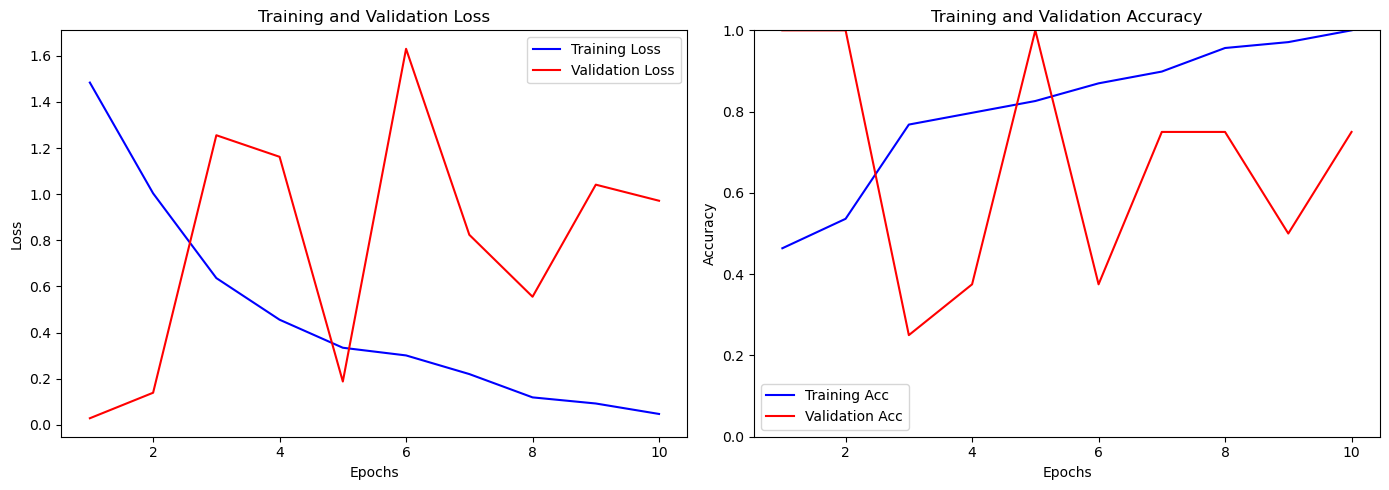

In [154]:
import matplotlib.pyplot as plt

# Retrieve history data
epochs = range(1, len(history.history['loss']) + 1)
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot training and validation loss
ax1.plot(epochs, loss, 'b', label='Training Loss')
ax1.plot(epochs, val_loss, 'r', label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot training and validation accuracy
ax2.plot(epochs, acc, 'b', label='Training Acc')
ax2.plot(epochs, val_acc, 'r', label='Validation Acc')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.set_ylim(0, 1)

# Show the plots
plt.tight_layout()
plt.show()


## 5. Evaluate model performance

In [155]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming `model` is your trained Keras model, df_train and df_test are your DataFrames
# and 'features' is the column with image features, 'label' is the column with true labels.

# Predict classes on training set
y_pred_train = (model.predict(X_train) > 0.5).astype("int32")
y_true_train = y_train

# Compute confusion matrix for training set
cm_train = confusion_matrix(y_true_train, y_pred_train)
acc_train = accuracy_score(y_true_train, y_pred_train)

# Predict classes on testing set
X_test = np.array(df_test['features'].tolist())
y_test = df_test['label'].apply(lambda x: 1 if x == 'malignant' else 0).values
y_pred_test = (model.predict(X_test) > 0.5).astype("int32")
y_true_test = y_test

# Compute confusion matrix for testing set
cm_test = confusion_matrix(y_true_test, y_pred_test)
acc_test = accuracy_score(y_true_test, y_pred_test)

3/3 [==============================] - 0s 764us/step


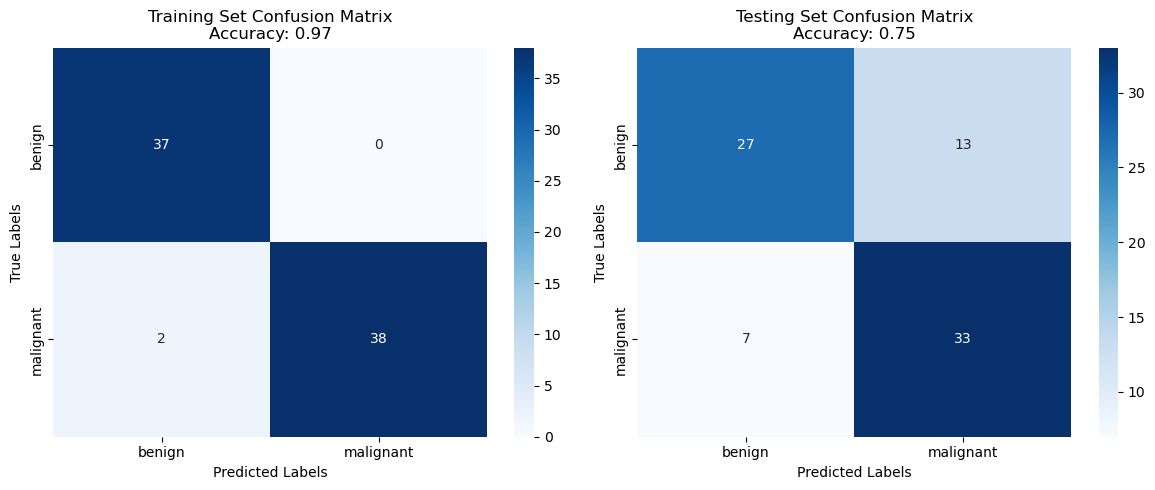

In [156]:
# Define a mapping from numeric labels to string labels
label_mapping = {0: 'benign', 1: 'malignant'}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Training Confusion Matrix
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=ax1, xticklabels=label_mapping.values(), yticklabels=label_mapping.values())
ax1.set_title(f'Training Set Confusion Matrix\nAccuracy: {acc_train:.2f}')
ax1.set_xlabel('Predicted Labels')
ax1.set_ylabel('True Labels')

# Testing Confusion Matrix
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=ax2, xticklabels=label_mapping.values(), yticklabels=label_mapping.values())
ax2.set_title(f'Testing Set Confusion Matrix\nAccuracy: {acc_test:.2f}')
ax2.set_xlabel('Predicted Labels')
ax2.set_ylabel('True Labels')

plt.tight_layout()
plt.show()

## 6. Save model and deploy

In [89]:
# Save model
model.save('mymodel.h5')

/Users/teosanchez/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


**Exercice** : Write a function that takes a raw image (PIL) and the model, and outputs a prediction (string) and a probability (float).

In [157]:
import PIL
from typing import Tuple

def predict(image: PIL.Image.Image, model: Model) -> Tuple[str, float]:
    """AI is creating summary for predict

    Args:
        image (PIL.Image.Image): An image to predict.
        model (Model): A model to use for prediction.

    Returns:
        Tuple[str, float]: A tuple of the predicted label and the confidence score.
    """
    # TODO: Implement this function
    raise NotImplementedError


predict(df_test['image'][0], model)

NotImplementedError: 

# Import a model trained in Marcelle

We reviewed all the steps to train a machine learning model in Python. However, if you want to use a model trained in Marcelle, you can import it in Python and use it to make predictions on new images following the steps below.

1. Go on the settings of the Marcelle application once you trained a model
2. Click on "Download Model". Two files should be downloaded: `classifier.json` and `mlpclassifier.weights(1).bin`. The first one describes the architecture of the model and the second one contains the weights of the model.
3. Convert the files using the following command:

 `tensorflowjs_converter --input_format=tfjs_layers_model --output_format=keras path/to/classifier.json path/to/converted/model`

4. Now follow the following steps to import the model in Python

In [158]:
from tensorflow import keras

# Make sure to replace './path/to/output/keras_model' with the actual path where the converted model is stored
def load_model(model_path):
    # This loads both the model architecture and the weights
    model = keras.models.load_model(model_path)
    return model

# Load the converted model (including weights)
model = load_model('./keras_model')

# Display the model architecture
print(model.summary())

# Now you can use the model for predictions, further training, evaluation, etc.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_Dense1 (Dense)        (None, 64)                65600     
                                                                 
 dense_Dense2 (Dense)        (None, 32)                2080      
                                                                 
 dense_Dense3 (Dense)        (None, 2)                 66        
                                                                 
Total params: 67746 (264.63 KB)
Trainable params: 67746 (264.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [171]:
# Use the model to make predictions
predictions = model.predict(df_test.features)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type numpy.ndarray).

In [173]:
# Assuming df_test.features is a pandas Series of 1D NumPy arrays:
# Stack the arrays to create one 2D NumPy array
X_test = np.stack(df_test.features.values)

# Now X_test is a 2D NumPy array that can be passed to the model for prediction
predictions = model.predict(X_test)
predictions

3/3 [==============================] - 0s 1ms/step


array([[0.36650518, 0.63349485],
       [0.28135037, 0.7186496 ],
       [0.38330564, 0.61669433],
       [0.4598815 , 0.54011846],
       [0.29996586, 0.7000341 ],
       [0.16229856, 0.83770144],
       [0.5527504 , 0.44724956],
       [0.07268341, 0.9273166 ],
       [0.14605302, 0.853947  ],
       [0.11634902, 0.88365096],
       [0.44228885, 0.5577111 ],
       [0.37331265, 0.6266874 ],
       [0.2166027 , 0.7833973 ],
       [0.10672177, 0.89327824],
       [0.1126862 , 0.88731384],
       [0.41449836, 0.5855017 ],
       [0.26708236, 0.7329176 ],
       [0.15937017, 0.8406298 ],
       [0.4379488 , 0.56205124],
       [0.09497558, 0.9050244 ],
       [0.13972194, 0.860278  ],
       [0.08297044, 0.9170296 ],
       [0.20203283, 0.7979672 ],
       [0.23221987, 0.7677801 ],
       [0.52525353, 0.4747464 ],
       [0.56770796, 0.432292  ],
       [0.12078129, 0.8792187 ],
       [0.5489216 , 0.4510784 ],
       [0.68002635, 0.31997362],
       [0.43927485, 0.56072515],
       [0.

In [178]:
import numpy as np
# Print predictions next to true labels
for i, (pred, true) in enumerate(zip(predictions, y_test)):
    print(f'Prediction: {np.argmax(pred):2} | Confidence: {max(pred):.2f} | True label: {true:2} |')

Prediction:  1 | Confidence: 0.63 | True label:  0 |
Prediction:  1 | Confidence: 0.72 | True label:  0 |
Prediction:  1 | Confidence: 0.62 | True label:  0 |
Prediction:  1 | Confidence: 0.54 | True label:  0 |
Prediction:  1 | Confidence: 0.70 | True label:  0 |
Prediction:  1 | Confidence: 0.84 | True label:  0 |
Prediction:  0 | Confidence: 0.55 | True label:  0 |
Prediction:  1 | Confidence: 0.93 | True label:  0 |
Prediction:  1 | Confidence: 0.85 | True label:  0 |
Prediction:  1 | Confidence: 0.88 | True label:  0 |
Prediction:  1 | Confidence: 0.56 | True label:  0 |
Prediction:  1 | Confidence: 0.63 | True label:  0 |
Prediction:  1 | Confidence: 0.78 | True label:  0 |
Prediction:  1 | Confidence: 0.89 | True label:  0 |
Prediction:  1 | Confidence: 0.89 | True label:  0 |
Prediction:  1 | Confidence: 0.59 | True label:  0 |
Prediction:  1 | Confidence: 0.73 | True label:  0 |
Prediction:  1 | Confidence: 0.84 | True label:  0 |
Prediction:  1 | Confidence: 0.56 | True label